# Notebook created for KPIs data analysis in the context of the TRACTOR project

In [54]:
import numpy as np
import pandas as pd
import os
import sys
from tqdm import tqdm
import pickle
import time
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Data loading

In [55]:
def load_csv_dataset(data_path, isControlClass, trial):
    # for each traffic type, let's load csv info using pandas
    embb_files = glob(os.path.join(data_path, os.path.join(trial, "embb_*clean.csv")))
    embb_data = pd.concat([pd.read_csv(f, sep=",") for f in embb_files])
    embb_data['class'] = [0 for i in range(len(embb_data))] #'embb'
    mmtc_files = glob(os.path.join(data_path, os.path.join(trial, "mmtc_*clean.csv")))
    mmtc_data = pd.concat([pd.read_csv(f, sep=",") for f in mmtc_files])
    mmtc_data['class'] = [1 for i in range(len(mmtc_data))] #'mmtc'
    if 'ul_rssi' in mmtc_data.columns:
        mmtc_data = mmtc_data.drop(['ul_rssi'], axis=1)
    urll_files = glob(os.path.join(data_path, os.path.join(trial, "urll*_*clean.csv")))
    urll_data = pd.concat([pd.read_csv(f, sep=",") for f in urll_files])
    urll_data['class'] = [2 for i in range(len(urll_data))] #'urll'
    if isControlClass and os.path.exists(os.path.join(data_path, os.path.join(trial, "null_clean.csv"))):
        ctrl_data = pd.read_csv(os.path.join(data_path, os.path.join(trial, "null_clean.csv")), sep=",")
        ctrl_data['class'] = [3 for i in range(len(ctrl_data))] #'ctrl'
        df = pd.concat([embb_data, mmtc_data, urll_data, ctrl_data])
    else:
        df = pd.concat([embb_data, mmtc_data, urll_data])
    columns_drop = ['Timestamp', 'tx_errors downlink (%)'] # ['Timestamp', 'tx_errors downlink (%)', 'dl_cqi']
    df.drop(columns_drop, axis=1, inplace=True)
    # drop specific columns
    return df


In [56]:
def gen_slice_dataset(trials, data_path, labels, normalize=False, mode='emuc'):
    isControlClass = True if 'c' in mode else False
    for ix, trial in enumerate(trials):
        print('Generating dataframe ', trial)
        new_df = load_csv_dataset(data_path, isControlClass, trial)

        if ix == 0:
            df = new_df
        else:
            df = pd.concat([df, new_df])
    df.reset_index(drop=True, inplace=True)
    # also create a normalized version of the features (each feature is normalized independently)
    df_norm = df.copy()

    columns_maxmin = {}
    if normalize:
        for column in df_norm: # last column is class
            if column != 'class':
                values = df_norm[column]
                col_max = values.max()
                col_min = values.min()
                print('Normalizing Col.', column, '-- Max', col_max, ', Min', col_min)
                df_norm[column] = (values - col_min) / (col_max - col_min)
                # store max/min values for later normalization
                columns_maxmin[column] = {'max': col_max, 'min': col_min}
        df = df_norm
        
    if mode == 'emuc':
        classes = [0, 1, 2, 3]
    elif mode == 'emu':
        classes = [0, 1, 2]
        
    for c in classes:
        nsamps_c = len(df[df['class'] == c])
        print('Class', labels[c], '=', nsamps_c, 'samples')

    return df, columns_maxmin

In [57]:
TRIALS = ['Trial1', 'Trial2', 'Trial3', 'Trial4', 'Trial5', 'Trial6']
data_path = '/Users/mqsirera/NEU/traffic_gen/logs/'
labels = {0: 'eMBB', 1: 'mMTC', 2: 'URLLC', 3: 'ctrl'}
df, _ = gen_slice_dataset(TRIALS, data_path, labels, True)

Generating dataframe  Trial1
Generating dataframe  Trial2
Generating dataframe  Trial3
Generating dataframe  Trial4
Generating dataframe  Trial5
Generating dataframe  Trial6
Normalizing Col. dl_mcs -- Max 27.7311 , Min 0.0
Normalizing Col. dl_n_samples -- Max 879 , Min 0
Normalizing Col. dl_buffer [bytes] -- Max 193816 , Min 0
Normalizing Col. tx_brate downlink [Mbps] -- Max 7.68685 , Min 0.0
Normalizing Col. tx_pkts downlink -- Max 264 , Min 0
Normalizing Col. dl_cqi -- Max 15.0 , Min 0.1
Normalizing Col. ul_mcs -- Max 16.3 , Min 0.0
Normalizing Col. ul_n_samples -- Max 875 , Min 0
Normalizing Col. ul_buffer [bytes] -- Max 150000 , Min 0
Normalizing Col. rx_brate uplink [Mbps] -- Max 14.9592 , Min 0.0
Normalizing Col. rx_pkts uplink -- Max 250 , Min 0
Normalizing Col. rx_errors uplink (%) -- Max 100.0 , Min 0.0
Normalizing Col. ul_sinr -- Max 39.3163 , Min 0.0
Normalizing Col. phr -- Max 31 , Min 0
Normalizing Col. sum_requested_prbs -- Max 13200 , Min 0
Normalizing Col. sum_granted_p

In [58]:
df.head()

,dl_mcs,dl_n_samples,dl_buffer [bytes],tx_brate downlink [Mbps],tx_pkts downlink,dl_cqi,ul_mcs,ul_n_samples,ul_buffer [bytes],rx_brate uplink [Mbps],rx_pkts uplink,rx_errors uplink (%),ul_sinr,phr,sum_requested_prbs,sum_granted_prbs,ul_turbo_iters,class
0,0.081136,0.027304,0.0,0.000616,0.026515,0.418344,0.717160,0.033143,0.0,0.006685,0.032,0.0,0.912316,1.0,0.000152,0.005312,0.1,0
1,0.093758,0.017065,0.0,0.000637,0.015152,0.453499,0.698221,0.024000,0.0,0.006685,0.024,0.0,0.924451,1.0,0.000000,0.003320,0.1,0
2,0.324545,0.004551,0.0,0.000237,0.003788,0.451901,0.674847,0.008000,0.0,0.006685,0.008,0.0,0.933887,1.0,0.000000,0.000664,0.1,0
3,0.000000,0.000000,0.0,0.000000,0.000000,0.429530,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0
4,0.000000,0.000000,0.0,0.000000,0.000000,0.440716,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0


In [6]:
for i in range(len(labels)):
    print('Class ', labels[i], ':')
    zero_rows = len(df[(df['class'] == i) & ((df == 0).astype(int).sum(axis=1) > 11)])
    n_samples = len(df[df['class'] == i])
    print('Presents', zero_rows, 'zero populated rows out of', n_samples, f'samples ({round(zero_rows/n_samples*100.0, 2)}%).')
print('\nZero populated row refers to a row with more than 11 KPIs equal to zero')

Class  eMBB :
Presents 26058 zero populated rows out of 38405 samples (67.85%).
Class  mMTC :
Presents 25923 zero populated rows out of 35886 samples (72.24%).
Class  URLLC :
Presents 1905 zero populated rows out of 17003 samples (11.2%).
Class  ctrl :
Presents 9618 zero populated rows out of 10230 samples (94.02%).

Zero populated row refers to a row with more than 11 KPIs equal to zero


In [7]:
print(df.shape)

(101524, 18)


Save the dataset

In [8]:
kpis = df.columns
kpis = kpis[:-1]
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
df_subset[kpis].to_csv('kpis.tsv', index=False, header=False, sep="\t")
df_subset['class'].to_csv('class.tsv', index=False, header=False, sep="\t")

## Analysis

### Mean and std deviation

We want to see the mean and standard deviation value for each KPI within each class

In [9]:
def calc_mean(data, cl, no_zeros=False):
    if no_zeros and cl != 3:
        data = data.loc[(data == 0).astype(int).sum(axis=1) < 11]
    return data.mean().to_list()[:-1]

def calc_std(data, cl, no_zeros=False):
    if no_zeros and cl != 3:
        data = data.loc[(data == 0).astype(int).sum(axis=1) < 11]
    return data.std().to_list()[:-1]

0 :  dl_mcs ; 1 :  dl_n_samples ; 2 :  dl_buffer [bytes] ; 3 :  tx_brate downlink [Mbps] ; 4 :  tx_pkts downlink ; 5 :  dl_cqi ; 6 :  ul_mcs ; 7 :  ul_n_samples ; 8 :  ul_buffer [bytes] ; 9 :  rx_brate uplink [Mbps] ; 10 :  rx_pkts uplink ; 11 :  rx_errors uplink (%) ; 12 :  ul_sinr ; 13 :  phr ; 14 :  sum_requested_prbs ; 15 :  sum_granted_prbs ; 16 :  ul_turbo_iters ; 

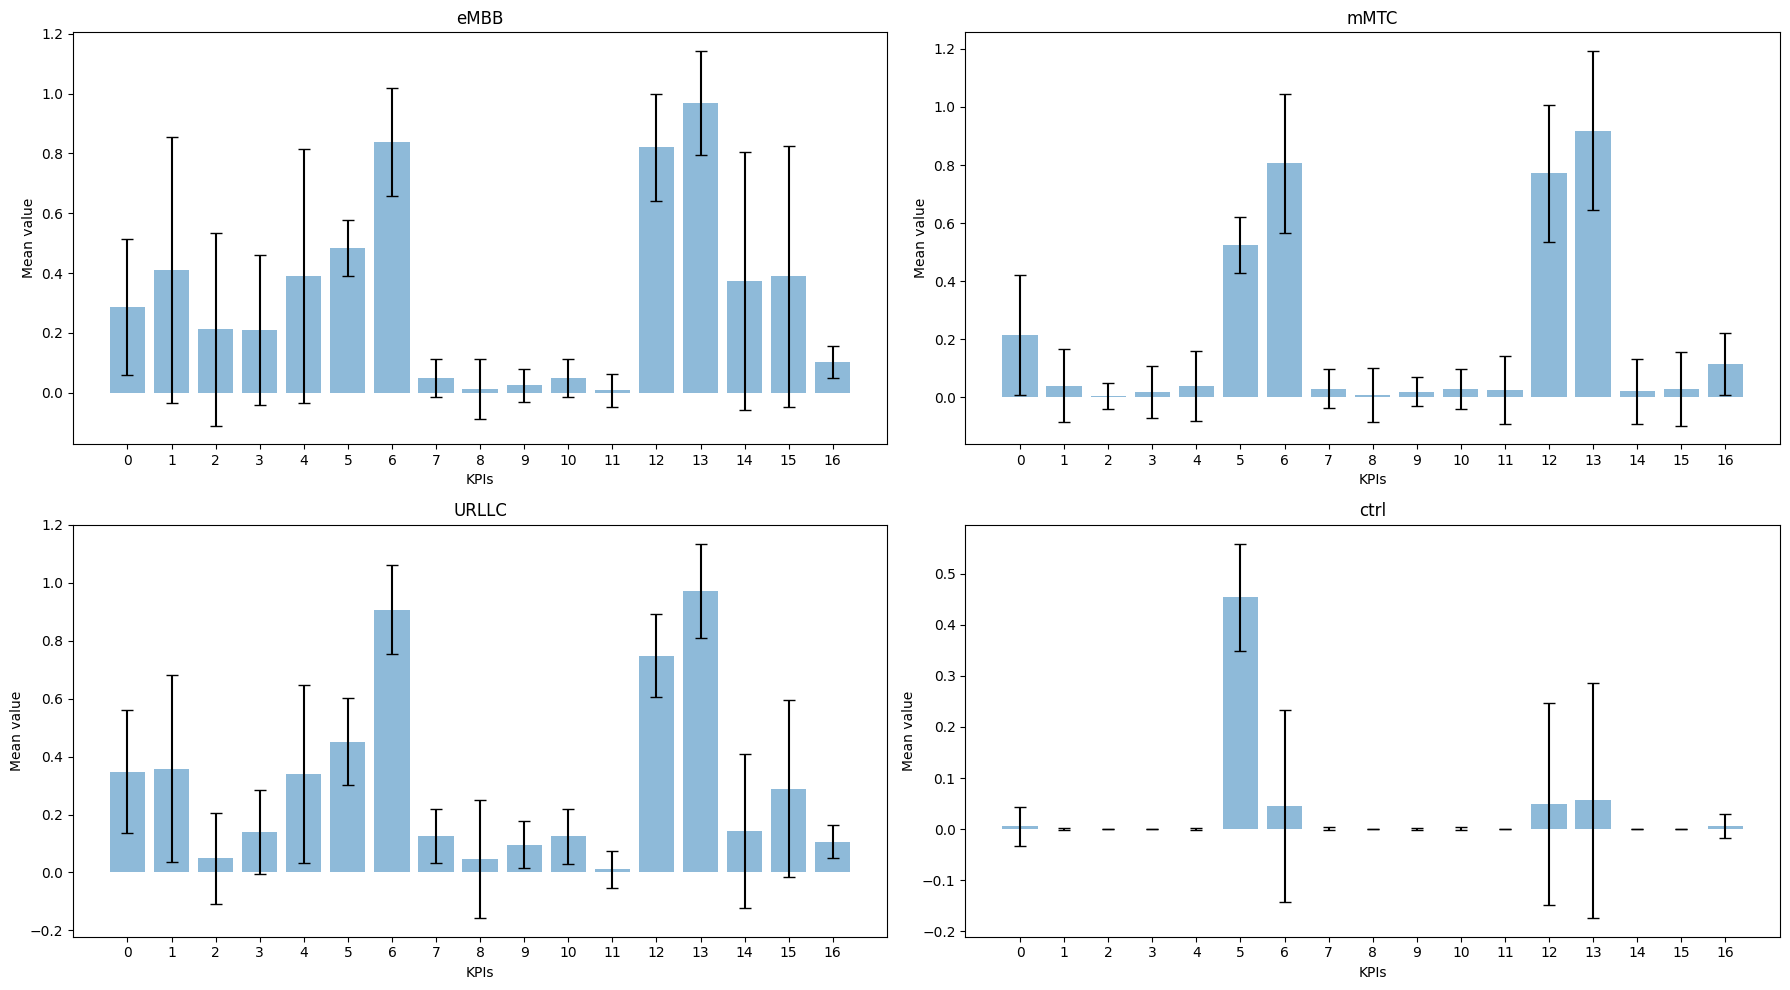

In [10]:
x = np.arange(17)
no_zeros=True
kpis = df.columns
kpis = kpis[:-1]
fig, ax = plt.subplots(2, 2, figsize = (18, 10))

for i in range(2):
    for j in range(2):
        ax[i][j].bar(x, calc_mean(df[df['class'] == i*2+j], i*2+j, no_zeros), yerr = calc_std(df[df['class'] == i*2+j], i*2+j, no_zeros), align='center', alpha=0.5, ecolor='black', capsize=4)
        ax[i][j].set_title(labels[i*2+j])
        ax[i][j].set_xlabel('KPIs')
        ax[i][j].set_xticks(x, np.arange(17))
        ax[i][j].set_ylabel('Mean value')
plt.tight_layout()

for i in range(17):
    print(i, ': ', kpis[i], end=' ; ')

0 :  dl_mcs ; 1 :  dl_n_samples ; 2 :  dl_buffer [bytes] ; 3 :  tx_brate downlink [Mbps] ; 4 :  tx_pkts downlink ; 5 :  dl_cqi ; 6 :  ul_mcs ; 7 :  ul_n_samples ; 8 :  ul_buffer [bytes] ; 9 :  rx_brate uplink [Mbps] ; 10 :  rx_pkts uplink ; 11 :  rx_errors uplink (%) ; 12 :  ul_sinr ; 13 :  phr ; 14 :  sum_requested_prbs ; 15 :  sum_granted_prbs ; 16 :  ul_turbo_iters ; 

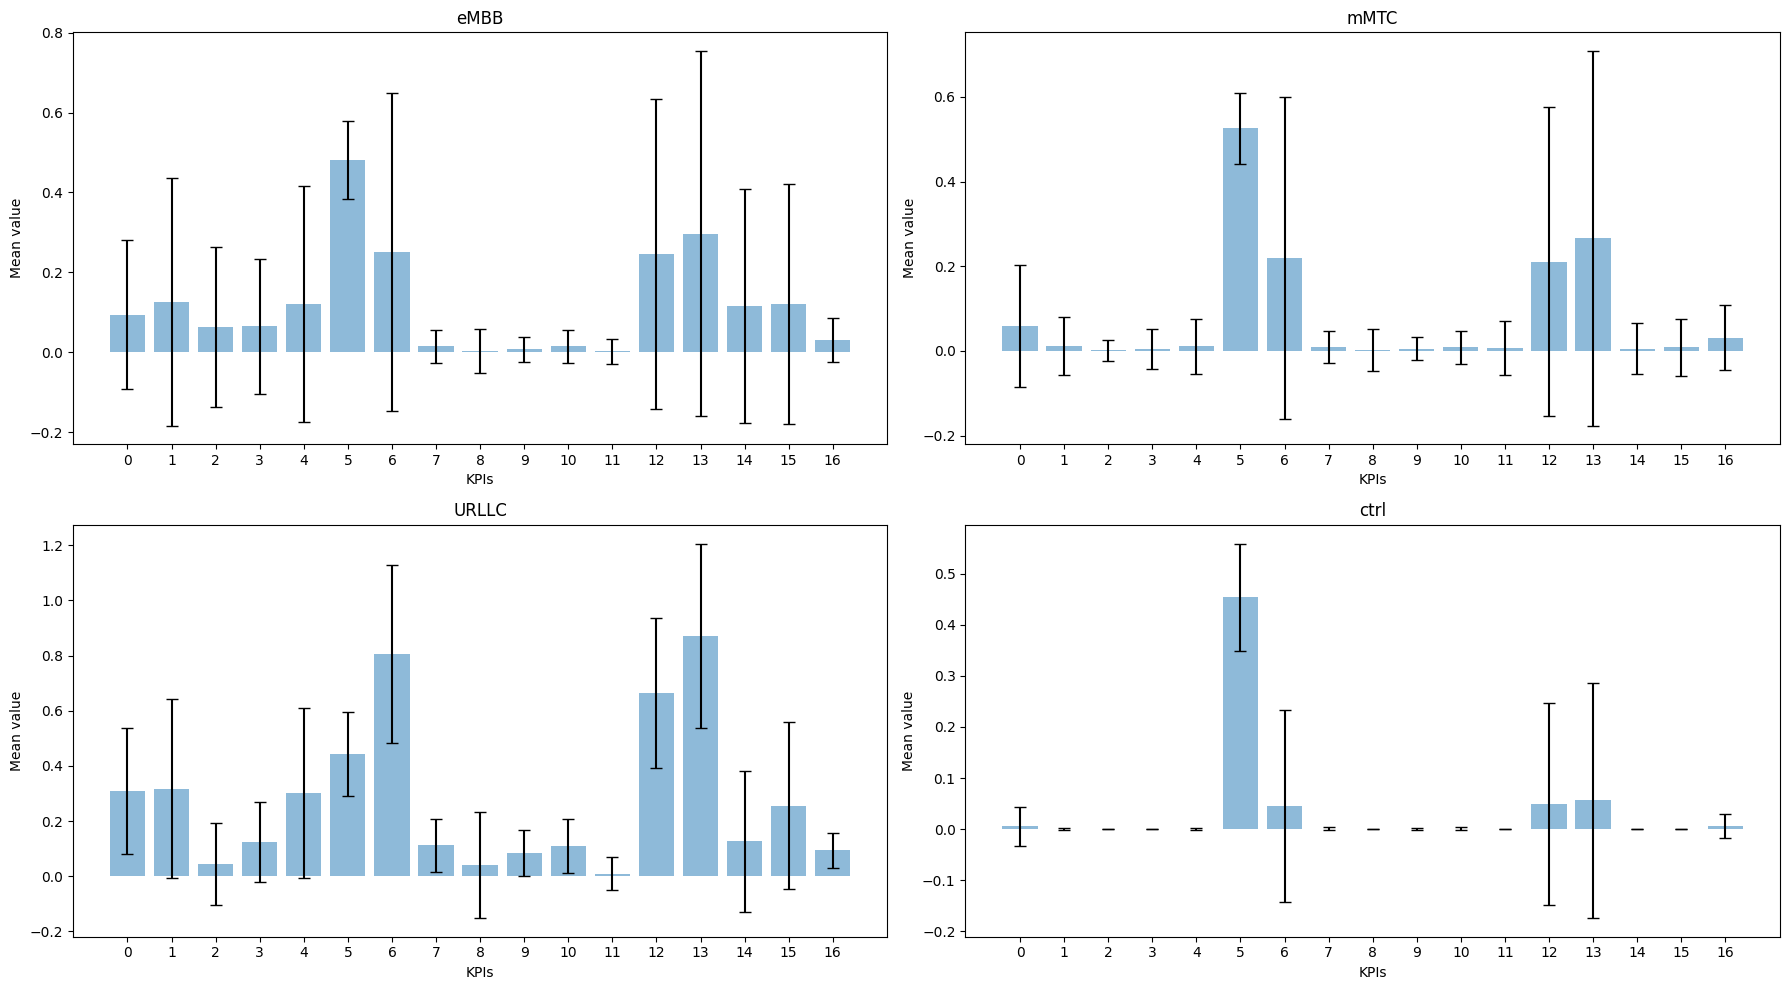

In [11]:
x = np.arange(17)
no_zeros=False
kpis = df.columns
kpis = kpis[:-1]
fig, ax = plt.subplots(2, 2, figsize = (18, 10))

for i in range(2):
    for j in range(2):
        ax[i][j].bar(x, calc_mean(df[df['class'] == i*2+j], i*2+j, no_zeros), yerr = calc_std(df[df['class'] == i*2+j], i*2+j, no_zeros), align='center', alpha=0.5, ecolor='black', capsize=4)
        ax[i][j].set_title(labels[i*2+j])
        ax[i][j].set_xlabel('KPIs')
        ax[i][j].set_xticks(x, np.arange(17))
        ax[i][j].set_ylabel('Mean value')
plt.tight_layout()

for i in range(17):
    print(i, ': ', kpis[i], end=' ; ')

### Dimensionality reduction

In [59]:
def closest_point_index(points, x, y, z=None):
    '''Returns the closest point in the dataset to the coordinates provided. Can work
       with 2D or 3D data, depending on if the argument z is provided'''
    point = (x, y) if z is None else (x, y, z)
    ix = cdist([point], points).argmin()
    return ix, points[ix]

#### T-SNE

In [60]:
kpis = df.columns
kpis = kpis[:-1]
np.random.seed(42)
N = 10000

for i in range(4):
    if i == 0:
        df_subset = df[df['class'] == i].sample(N, ignore_index=True)
    else:
        df_subset = pd.concat([df_subset, df[df['class'] == i].sample(N)], ignore_index=True)
df_subset.reset_index(drop=True, inplace=True)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=55, n_iter=300)
tsne_results = tsne.fit_transform(df_subset[kpis].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/Users/mqsirera/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mqsirera/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.001s...
[t-SNE] Computed neighbors for 40000 samples in 25.655s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for s

In [61]:
labels

{0: 'eMBB', 1: 'mMTC', 2: 'URLLC', 3: 'ctrl'}

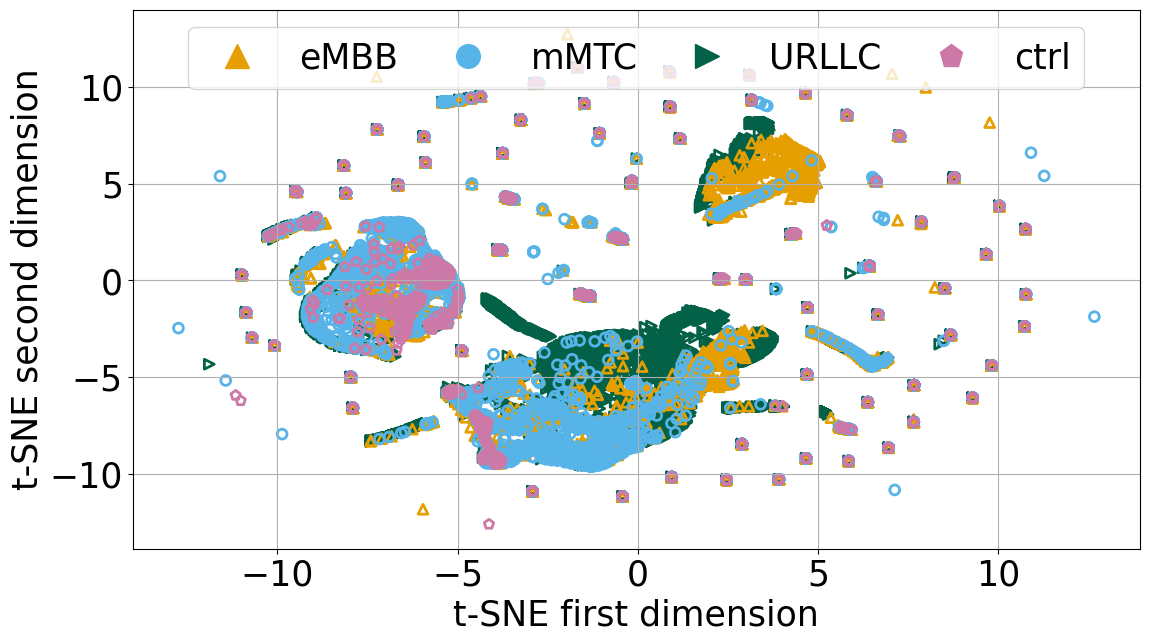

In [65]:
import matplotlib.lines as mlines
colorblind_friendly = True
if colorblind_friendly: 
    colors = ["#E69F00", "#56B4E9", "#026147", "#CC79A7"] # colorblind_friendly
else:
    colors = ["#D97652", "#56A662", "#BF4E58", "#8172B3"] # paper palette

markers = ["^", "o", ">", "p"]
l = list(labels.values())
font = {'size'   : 25}

matplotlib.rc('font', **font)
plt.figure(figsize=(13,7))
df_plot = pd.DataFrame.from_dict({'t-SNE first dimension': tsne_results[:,0], 't-SNE second dimension': tsne_results[:,1]})
df_plot['Class'] = df_subset['class']
df_plot['point'] = [(x, y) for x,y in zip(df_plot['t-SNE first dimension'], df_plot['t-SNE second dimension'])]

new_order = [2, 0, 1, 3]
for i in new_order:
    df_plot_class = df_plot.loc[df_plot['Class'] == i]
    plt.scatter(
        x="t-SNE first dimension", y="t-SNE second dimension",
        c=colors[i],
        s=50,
        marker=matplotlib.markers.MarkerStyle(markers[i], fillstyle='none'), 
        data=df_plot_class,
        linewidth=2,
        alpha=1,
        facecolor="none",
        label=labels[i]
    )
plt.grid()


embb = mlines.Line2D([], [], color=colors[0], marker=markers[0], linestyle='None', markersize=17)
mmtc = mlines.Line2D([], [], color=colors[1], marker=markers[1], linestyle='None', markersize=17)
urllc = mlines.Line2D([], [], color=colors[2], marker=markers[2], linestyle='None', markersize=17)
ctrl = mlines.Line2D([], [], color=colors[3], marker=markers[3], linestyle='None', markersize=17)

plt.legend(handles=[embb, mmtc, urllc, ctrl], labels=l, loc = 'upper center', ncols=4, columnspacing=1)
#legend = plt.legend(loc = 'upper center', markerscale=2.5, ncols=4, columnspacing=0.2)
plt.xlabel('t-SNE first dimension')
plt.ylabel('t-SNE second dimension')
plt.savefig(f"tsne.pdf")

#ix, point = closest_point_index(list(df_plot['point']), 0, 0)
#print(ix, point, df_subset.iloc[ix])

In [31]:
len(df_plot[df_plot.Class == 'URLLC'])

10000

#### PCA

In [103]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_subset[kpis].values)

df_plot = pd.DataFrame.from_dict({'pca-one': pca_result[:,0], 'pca-two': pca_result[:,1], 'pca-three': pca_result[:,2]})
df_plot['class'] = df_subset['class']

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.73661527 0.17094481 0.02976851]


In [104]:
np.round(pca.components_, 3)

array([[ 0.186,  0.225,  0.064,  0.097,  0.214, -0.005,  0.513,  0.06 ,
         0.02 ,  0.044,  0.06 ,  0.006,  0.45 ,  0.564,  0.135,  0.196,
         0.062],
       [ 0.08 ,  0.449,  0.204,  0.195,  0.427, -0.006, -0.241,  0.034,
         0.004,  0.019,  0.034,  0.005, -0.234, -0.271,  0.387,  0.437,
        -0.023],
       [-0.669, -0.058,  0.322, -0.189, -0.057, -0.447,  0.027, -0.161,
        -0.066, -0.135, -0.162, -0.02 ,  0.097,  0.112,  0.327,  0.043,
        -0.008]])

<Axes: xlabel='pca-one', ylabel='pca-two'>

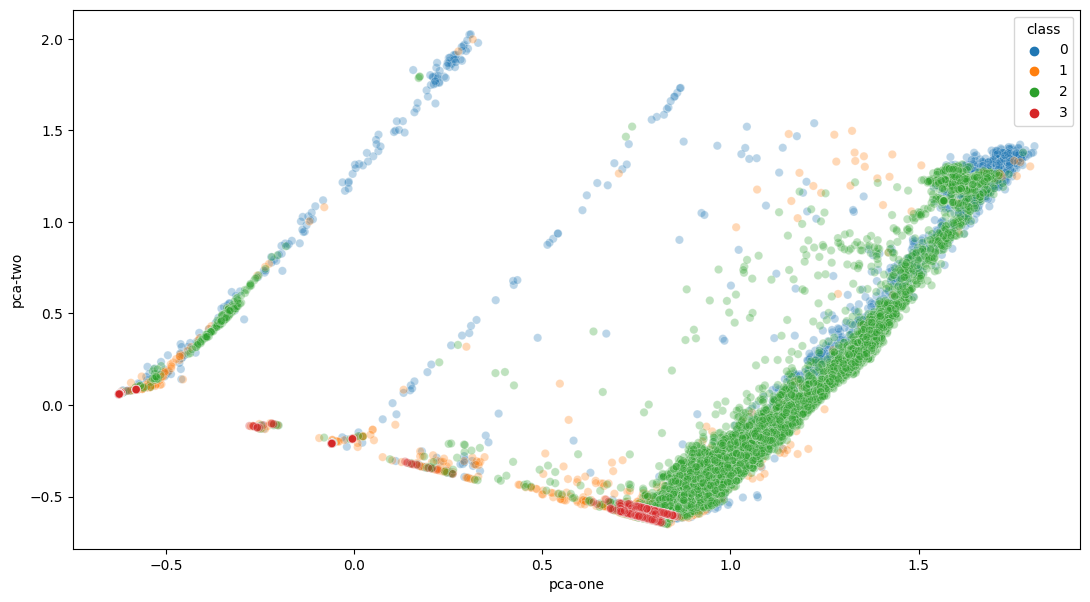

In [76]:
plt.figure(figsize=(13, 7))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="class",
    palette=sns.color_palette("tab10", 4),
    data=df_plot,
    legend="full",
    alpha=0.3
)

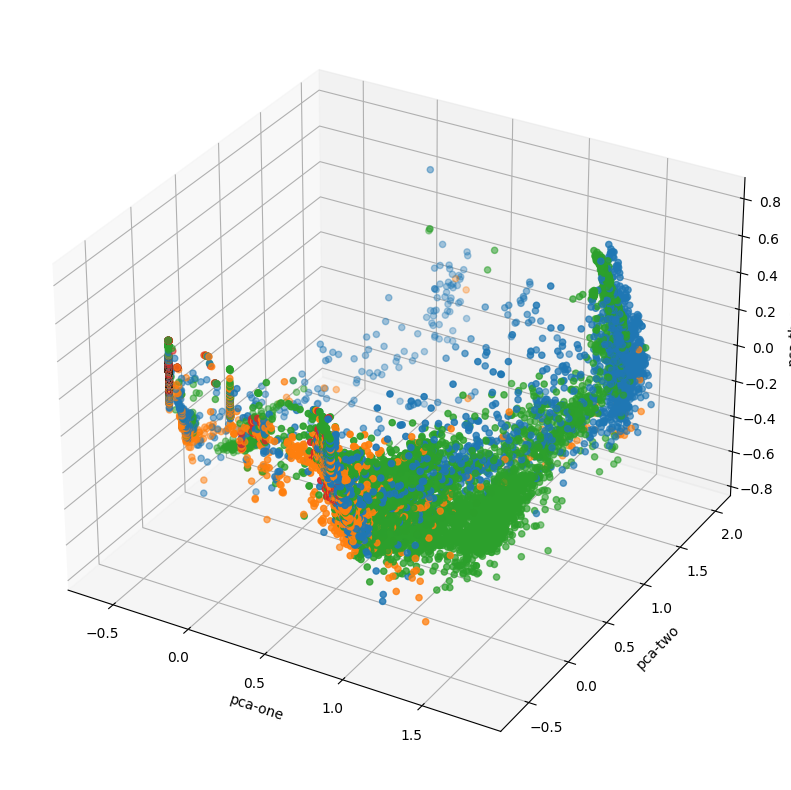

In [77]:
%matplotlib inline
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("tab10", 4).as_hex())
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=df_subset["pca-one"], 
    ys=df_subset["pca-two"], 
    zs=df_subset["pca-three"], 
    c=df_subset["class"], 
    cmap=my_cmap
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

#### T-SNE with slices

In [8]:
def check_slices(data, index, check=True):
    labels = np.ones((data.shape[0],), dtype=np.int32)*index
    count = 0
    if check:
        for i in range(data.shape[0]):
            sl = data[i]
            zeros = (sl == 0).astype(int).sum(axis=1)
            if (zeros > 10).all():
                count += 1
                labels[i] = 3 # control if all KPIs rows have > 10 zeros
    return labels, count
    

def gen_slice_dataset(trials, data_path, slice_len, labels, normalize, mode='emuc'):

    isControlClass = True if 'c' in mode else False
    trials_in = []
    trials_lbl = []
    for trial in trials:
        print('Generating dataset ', trial)
        ctrl_data, embb_data, mmtc_data, urll_data = load_csv_dataset(data_path, isControlClass, trial)

        # stack together all data from all traffic class
        if isControlClass and os.path.exists(os.path.join(data_path, os.path.join(trial, "null_clean.csv"))):
            datasets = [embb_data, mmtc_data, urll_data, ctrl_data]
        else:
            datasets = [embb_data, mmtc_data, urll_data]

        for ix, ds in enumerate(datasets):
            new_ds = []
            # let's first remove undesired columns from the dataframe (these features are not relevant for traffic classification)
            columns_drop = ['Timestamp', 'tx_errors downlink (%)'] # ['Timestamp', 'tx_errors downlink (%)', 'dl_cqi']
            ds.drop(columns_drop, axis=1, inplace=True)
            for i in tqdm(range(ds.shape[0]), desc='Slicing..'):
                if i + slice_len < ds.shape[0]:
                    new_ds.append(
                        ds[i:i + slice_len]  # slice
                    )
            new_ds = np.array(new_ds)

            print("Generating ORAN traffic KPI dataset")
            # create labels based on dataset generation mode
            if mode == 'emu' or mode == 'emuc':

                if ix == 0:
                    print("\teMBB class")
                    embb_data = new_ds
                    embb_labels, embb_relabel = check_slices(embb_data, ix) # labels are numbers (i.e. no 1 hot encoded)
                    print(embb_relabel)
                elif ix == 1:
                    print("\tMMTc class")
                    mmtc_data = new_ds
                    mmtc_labels, mmtc_relabel = check_slices(mmtc_data, ix)
                    print(mmtc_relabel)
                elif ix == 2:
                    print("\tURLLc class")
                    urll_data = new_ds
                    urll_labels, urll_relabel = check_slices(urll_data, ix)
                    print(urll_relabel)
                elif ix == 3:
                    print("\tControl / CTRL class")
                    ctrl_data = new_ds
                    ctrl_labels = np.ones((ctrl_data.shape[0],), dtype=np.int32)*ix
            else:
                if ix < 3:
                    print("Active traffic class")
                    if ix == 0:
                        embb_data = new_ds
                        embb_labels = np.zeros((embb_data.shape[0],), dtype=np.int32) # labels are numbers (i.e. no 1 hot encoded)
                    elif ix == 1:
                        mmtc_data = new_ds
                        mmtc_labels = np.zeros((mmtc_data.shape[0],), dtype=np.int32)
                    elif ix == 2:
                        urll_data = new_ds
                        urll_labels = np.zeros((urll_data.shape[0],), dtype=np.int32)
                else:
                    print("\tControl / CTRL class")
                    ctrl_data = new_ds
                    ctrl_labels = np.ones((ctrl_data.shape[0],), dtype=np.int32)

        if isControlClass and os.path.exists(os.path.join(data_path, os.path.join(trial, "null_clean.csv"))):
            all_input = np.concatenate((embb_data, mmtc_data, urll_data, ctrl_data), axis=0)
            all_labels = np.concatenate((embb_labels, mmtc_labels, urll_labels, ctrl_labels), axis=0)
        else:
            all_input = np.concatenate((embb_data, mmtc_data, urll_data), axis=0)
            all_labels = np.concatenate((embb_labels, mmtc_labels, urll_labels), axis=0)


        trials_in.append(all_input)
        trials_lbl.append(all_labels)

    trials_in = np.concatenate(trials_in, axis=0).astype(np.float32)
    trials_lbl = np.concatenate(trials_lbl, axis=0).astype(int)

    # also create a normalized version of the features (each feature is normalized independently)
    trials_in_norm = trials_in.copy()

    columns_maxmin = {}
    for c in range(trials_in_norm.shape[2]):
        col_max = trials_in_norm[:,:,c].max()
        col_min = trials_in_norm[:,:,c].min()
        print('Normalizing Col.', c, '-- Max', col_max, ', Min', col_min)
        trials_in_norm[:, :, c] = (trials_in_norm[:, :, c] - col_min) / (col_max - col_min)
        # store max/min values for later normalization
        columns_maxmin[c] = {'max': col_max, 'min': col_min}
    
    final_df = []
    for sl in trials_in_norm:
        final_df.append(sl.flatten())
    if mode == 'emuc':
        classes = [0, 1, 2, 3]
    elif mode == 'emu':
        classes = [0, 1, 2]
        
    for c in classes:
        nsamps_c = np.where(trials_lbl == c)[0].shape[0]
        print('Class', labels[c], '=', nsamps_c, 'samples')
    
    if normalize:
        return np.array(final_df), trials_lbl, columns_maxmin
    return trials_in, trials_lbl, columns_maxmin


def load_csv_dataset(data_path, isControlClass, trial):
    # for each traffic type, let's load csv info using pandas
    embb_files = glob(os.path.join(data_path, os.path.join(trial, "embb_*clean.csv")))
    embb_data = pd.concat([pd.read_csv(f, sep=",") for f in embb_files])
    mmtc_files = glob(os.path.join(data_path, os.path.join(trial, "mmtc_*clean.csv")))
    mmtc_data = pd.concat([pd.read_csv(f, sep=",") for f in mmtc_files])
    urll_files = glob(os.path.join(data_path, os.path.join(trial, "urll*_*clean.csv")))
    urll_data = pd.concat([pd.read_csv(f, sep=",") for f in urll_files])
    if isControlClass and os.path.exists(os.path.join(data_path, os.path.join(trial, "null_clean.csv"))):
        ctrl_data = pd.read_csv(os.path.join(data_path, os.path.join(trial, "null_clean.csv")), sep=",")
    else:
        ctrl_data = None
    # drop specific columns
    if 'ul_rssi' in mmtc_data.columns:
        mmtc_data = mmtc_data.drop(['ul_rssi'], axis=1)
    return ctrl_data, embb_data, mmtc_data, urll_data


In [11]:
TRIALS = ['Trial1', 'Trial2', 'Trial3', 'Trial4', 'Trial5', 'Trial6']
data_path = '/Users/mqsirera/NEU/traffic_gen/logs/'
labels = {0: 'embb', 1: 'mmtc', 2: 'urll', 3: 'ctrl'}
data, lbs, _ = gen_slice_dataset(TRIALS, data_path, 32, labels, True)

Generating dataset  Trial1


Slicing..: 100%|████████████████████████████████████████████████████| 4409/4409 [00:00<00:00, 30203.43it/s]


Generating ORAN traffic KPI dataset
	eMBB class
0


Slicing..: 100%|██████████████████████████████████████████████████| 14631/14631 [00:00<00:00, 44655.06it/s]


Generating ORAN traffic KPI dataset
	MMTc class
0


Slicing..: 100%|████████████████████████████████████████████████████| 1347/1347 [00:00<00:00, 68798.44it/s]


Generating ORAN traffic KPI dataset
	URLLc class
0
Generating dataset  Trial2


Slicing..: 100%|████████████████████████████████████████████████████| 5848/5848 [00:00<00:00, 39883.27it/s]


Generating ORAN traffic KPI dataset
	eMBB class
0


Slicing..: 100%|████████████████████████████████████████████████████| 3810/3810 [00:00<00:00, 44256.58it/s]


Generating ORAN traffic KPI dataset
	MMTc class
0


Slicing..: 100%|██████████████████████████████████████████████████████| 165/165 [00:00<00:00, 85009.23it/s]


Generating ORAN traffic KPI dataset
	URLLc class
0
Generating dataset  Trial3


Slicing..: 100%|████████████████████████████████████████████████████| 3419/3419 [00:00<00:00, 41109.90it/s]


Generating ORAN traffic KPI dataset
	eMBB class
0


Slicing..: 100%|████████████████████████████████████████████████████| 1152/1152 [00:00<00:00, 73954.82it/s]


Generating ORAN traffic KPI dataset
	MMTc class
0


Slicing..: 100%|████████████████████████████████████████████████████| 1932/1932 [00:00<00:00, 73178.93it/s]


Generating ORAN traffic KPI dataset
	URLLc class
0
Generating dataset  Trial4


Slicing..: 100%|████████████████████████████████████████████████████| 3430/3430 [00:00<00:00, 44003.78it/s]


Generating ORAN traffic KPI dataset
	eMBB class
0


Slicing..: 100%|████████████████████████████████████████████████████| 1567/1567 [00:00<00:00, 72338.67it/s]


Generating ORAN traffic KPI dataset
	MMTc class
0


Slicing..: 100%|████████████████████████████████████████████████████| 1890/1890 [00:00<00:00, 34310.65it/s]


Generating ORAN traffic KPI dataset
	URLLc class
0


Slicing..: 100%|████████████████████████████████████████████████████| 5202/5202 [00:00<00:00, 59277.25it/s]


Generating ORAN traffic KPI dataset
	Control / CTRL class
Generating dataset  Trial5


Slicing..: 100%|████████████████████████████████████████████████████| 4814/4814 [00:00<00:00, 47704.44it/s]


Generating ORAN traffic KPI dataset
	eMBB class
0


Slicing..: 100%|████████████████████████████████████████████████████| 1356/1356 [00:00<00:00, 28011.19it/s]


Generating ORAN traffic KPI dataset
	MMTc class
0


Slicing..: 100%|████████████████████████████████████████████████████| 5016/5016 [00:00<00:00, 47127.75it/s]


Generating ORAN traffic KPI dataset
	URLLc class
0


Slicing..: 100%|████████████████████████████████████████████████████| 5028/5028 [00:00<00:00, 57516.08it/s]


Generating ORAN traffic KPI dataset
	Control / CTRL class
Generating dataset  Trial6


Slicing..: 100%|██████████████████████████████████████████████████| 16485/16485 [00:00<00:00, 39728.26it/s]


Generating ORAN traffic KPI dataset
	eMBB class
0


Slicing..: 100%|██████████████████████████████████████████████████| 13370/13370 [00:00<00:00, 35831.73it/s]


Generating ORAN traffic KPI dataset
	MMTc class
0


Slicing..: 100%|████████████████████████████████████████████████████| 6653/6653 [00:00<00:00, 40430.76it/s]


Generating ORAN traffic KPI dataset
	URLLc class
0
Normalizing Col. 0 -- Max 27.7311 , Min 0.0
Normalizing Col. 1 -- Max 879.0 , Min 0.0
Normalizing Col. 2 -- Max 193816.0 , Min 0.0
Normalizing Col. 3 -- Max 7.68685 , Min 0.0
Normalizing Col. 4 -- Max 264.0 , Min 0.0
Normalizing Col. 5 -- Max 15.0 , Min 0.1
Normalizing Col. 6 -- Max 16.3 , Min 0.0
Normalizing Col. 7 -- Max 875.0 , Min 0.0
Normalizing Col. 8 -- Max 150000.0 , Min 0.0
Normalizing Col. 9 -- Max 14.9592 , Min 0.0
Normalizing Col. 10 -- Max 250.0 , Min 0.0
Normalizing Col. 11 -- Max 100.0 , Min 0.0
Normalizing Col. 12 -- Max 39.3163 , Min 0.0
Normalizing Col. 13 -- Max 31.0 , Min 0.0
Normalizing Col. 14 -- Max 13200.0 , Min 0.0
Normalizing Col. 15 -- Max 4518.0 , Min 0.0
Normalizing Col. 16 -- Max 10.0 , Min 0.0
Class embb = 38213 samples
Class mmtc = 35694 samples
Class urll = 16811 samples
Class ctrl = 10166 samples


In [80]:
data.shape, lbs.shape

((101444, 68), (101444,))

In [81]:
np.random.seed(42)
data = pd.DataFrame(data)
data['class'] = lbs
N = 10000
for i in range(4):
    if i == 0:
        data_subset = data[data['class'] == i].sample(10000, ignore_index=True)
    else:
        data_subset = pd.concat([data_subset, data[data['class'] == i].sample(10000)], ignore_index=True)
data_subset.reset_index(drop=True, inplace=True)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset.drop(['class'], axis=1))

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/Users/mqsirera/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mqsirera/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.001s...
[t-SNE] Computed neighbors for 40000 samples in 26.600s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for s

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

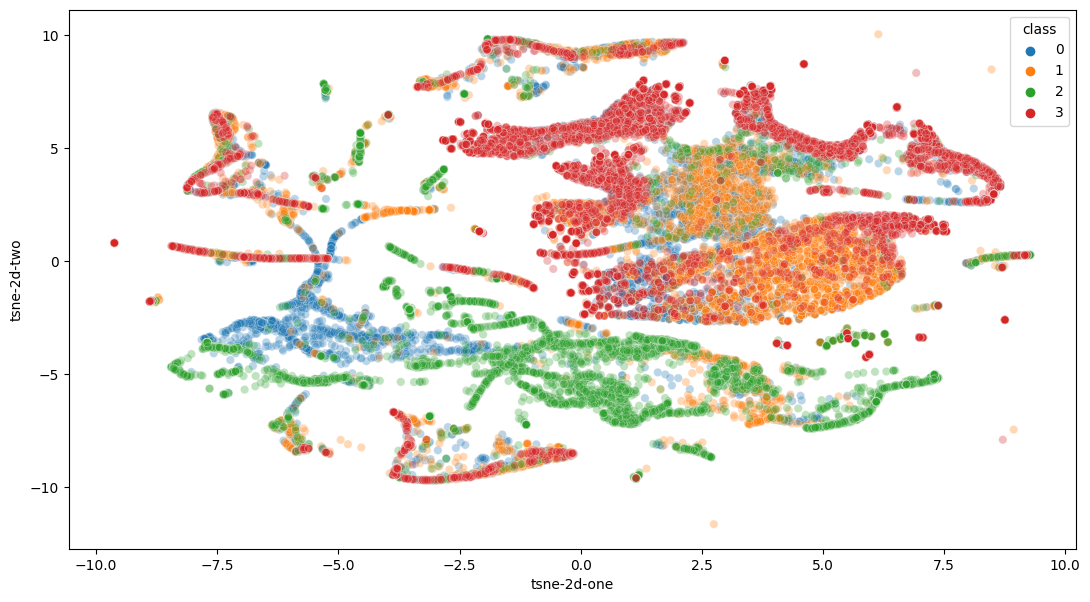

In [82]:
plt.figure(figsize=(13,7))
df_plot = pd.DataFrame.from_dict({'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1]})
df_plot['class'] = data_subset['class']
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='class',
    palette=sns.color_palette("tab10", 4),
    data=df_plot,
    legend="full",
    alpha=0.3
)

In [83]:
len(df_plot)

40000

#### PCA with slices

In [84]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_plot = pd.DataFrame.from_dict({'pca-one': pca_result[:,0], 'pca-two': pca_result[:,1], 'pca-three': pca_result[:,2]})
df_plot['class'] = lbs_subset

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.45326288 0.2529247  0.09502725]


/Users/mqsirera/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<Axes: xlabel='pca-one', ylabel='pca-two'>

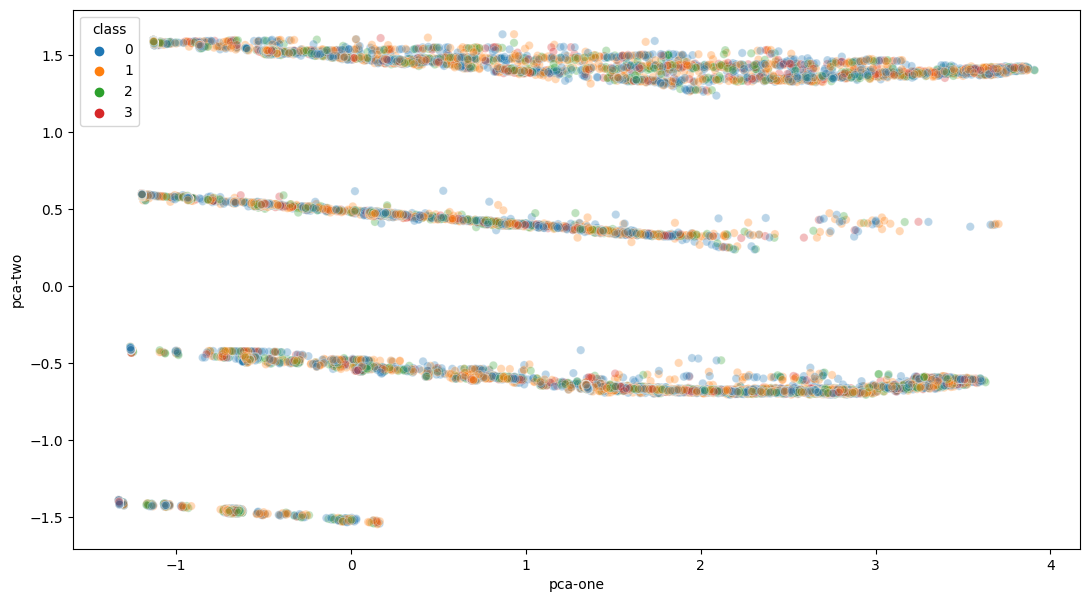

In [85]:
plt.figure(figsize=(13, 7))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="class",
    palette=sns.color_palette("tab10", 4),
    data=df_plot,
    legend="full",
    alpha=0.3
)

In [90]:
np.round(pca.components_, 3)

array([[ 0.1  ,  0.133,  0.038,  0.056,  0.126, -0.003,  0.244,  0.035,
         0.012,  0.026,  0.035,  0.004,  0.206,  0.263,  0.079,  0.116,
         0.03 ,  0.103,  0.137,  0.04 ,  0.059,  0.131, -0.003,  0.248,
         0.036,  0.012,  0.026,  0.036,  0.004,  0.211,  0.268,  0.083,
         0.12 ,  0.03 ,  0.105,  0.139,  0.039,  0.06 ,  0.133, -0.003,
         0.247,  0.035,  0.012,  0.026,  0.035,  0.004,  0.209,  0.267,
         0.085,  0.122,  0.03 ,  0.103,  0.137,  0.037,  0.059,  0.131,
        -0.003,  0.239,  0.035,  0.011,  0.025,  0.035,  0.004,  0.202,
         0.258,  0.083,  0.12 ,  0.029, -0.066],
       [-0.01 , -0.004,  0.014,  0.003, -0.004,  0.017, -0.029, -0.01 ,
        -0.004, -0.009, -0.01 ,  0.   , -0.013, -0.023,  0.018,  0.002,
        -0.002, -0.011, -0.004,  0.013,  0.003, -0.004,  0.017, -0.03 ,
        -0.01 , -0.004, -0.009, -0.01 ,  0.   , -0.014, -0.024,  0.018,
         0.002, -0.003, -0.011, -0.004,  0.013,  0.003, -0.004,  0.018,
        -0.027,

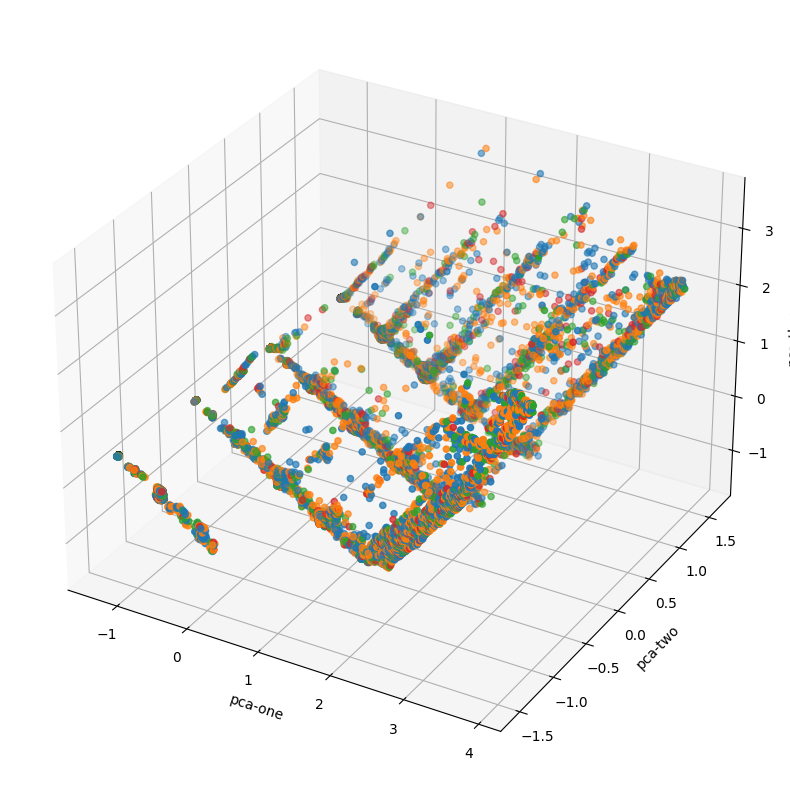

In [86]:
%matplotlib inline
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("tab10", 4).as_hex())
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=df_plot["pca-one"], 
    ys=df_plot["pca-two"], 
    zs=df_plot["pca-three"], 
    c=df_plot["class"], 
    cmap=my_cmap
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Results visualization

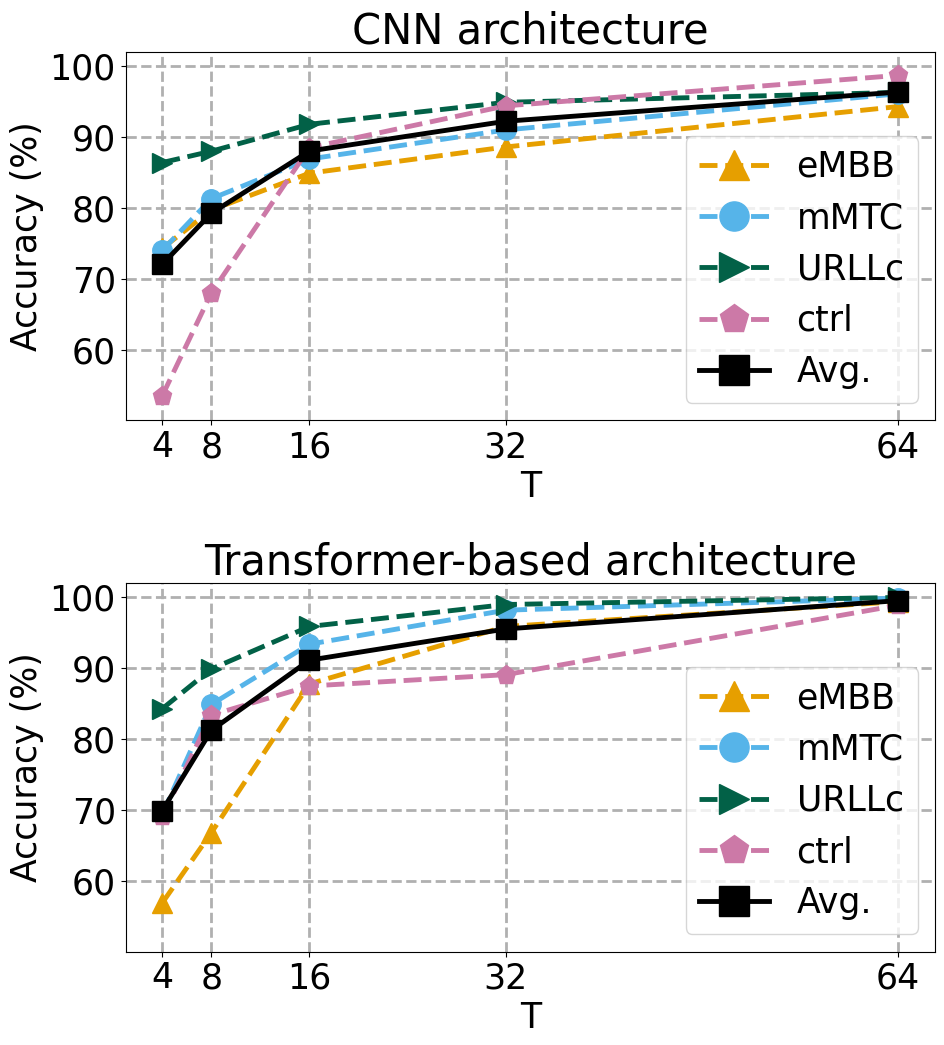

In [66]:
types = ['eMBB', 'mMTC', 'URLLc', 'ctrl', 'Avg.']
colorblind_friendly = True
if colorblind_friendly: 
    colors = ["#E69F00", "#56B4E9", "#026147", "#CC79A7", "#000000"] # colorblind_friendly
else:
    colors = ["#D97652", "#56A662", "#BF4E58", "#8172B3", '#4971A6'] # paper palette

line_s = ['dashed', 'dashed', 'dashed', 'dashed', 'solid']
markers = ["^", "o", ">", "p", "s"]
font = {'size'   : 25}

matplotlib.rc('font', **font)
x = [4, 8, 16, 32, 64]
# CNN data
embb_cnn = [74.3, 79.7, 84.9, 88.6, 94.3]
mmtc_cnn = [74.0, 81.3, 86.9, 91.0, 96.1]
urll_cnn = [86.4, 88.0, 91.8, 94.9, 96.3]
ctrl_cnn = [53.5, 68.0, 88.5, 94.4, 98.7]
avg_cnn = np.matrix([embb_cnn, mmtc_cnn, urll_cnn, ctrl_cnn])
avg_cnn = avg_cnn.mean(0)
cnn_lines = [embb_cnn, mmtc_cnn, urll_cnn, ctrl_cnn, avg_cnn.tolist()[0]]
# Trans. data
embb_tr = [56.9, 66.8, 87.8, 95.9, 99.4]
mmtc_tr = [69.4, 84.9, 93.4, 98.2, 99.9]
urll_tr = [84.3, 89.9, 95.9, 99.0, 100.0]
ctrl_tr = [69.1, 83.4, 87.5, 89.1, 98.9]
avg_tr = np.matrix([embb_tr, mmtc_tr, urll_tr, ctrl_tr])
avg_tr = avg_tr.mean(0)
tr_lines = [embb_tr, mmtc_tr, urll_tr, ctrl_tr, avg_tr.tolist()[0]]

fig, ax = plt.subplots(2, 1, figsize = (10, 11))
for i in range(5):
    ax[0].plot(x, cnn_lines[i], color=colors[i], marker=markers[i], linewidth=3.5, markersize=14, linestyle=line_s[i], label=types[i])
    ax[1].plot(x, tr_lines[i], color=colors[i], marker=markers[i], linewidth=3.5, markersize=14, linestyle=line_s[i], label=types[i])

for i in range(2):
    ax[i].set_ylim(50, 102)
    ax[i].set_xlabel('T')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_xticks(x)
    ax[i].set_yticks([60,70,80,90,100])
    ax[i].grid(linestyle='--', linewidth=2)
    ax[i].legend(markerscale=1.5)
    
ax[0].set_title('CNN architecture')
ax[1].set_title('Transformer-based architecture')
plt.tight_layout()
plt.savefig(f"fig6.pdf")


## CTRL class profiling

In [132]:
########################## FUTURE WORK ###############################

## Classifiers

Let's evaluate the performance of a SVM classifier in sample granularity

In [28]:
X = df.drop('class', axis=1, inplace=False)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight='balanced'))
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.5604980103226823


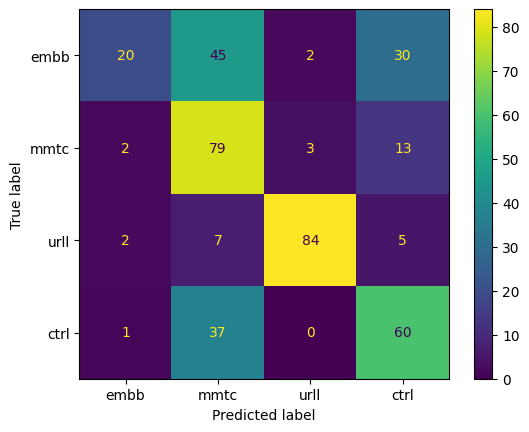

In [16]:
cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
for r in range(cm.shape[0]):  # for each row in the confusion matrix
    sum_row = np.sum(cm[r, :])
    cm[r, :] = cm[r, :] / sum_row  * 100.# compute in percentage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.values())
disp.plot()

Now for Random Forest classifier

In [54]:
X = df.drop('class', axis=1, inplace=False)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
rft = RandomForestClassifier(max_depth=6, random_state=0, class_weight='balanced')
rft.fit(X_train, y_train)
print(rft.score(X_test, y_test))


0.5543910799416887


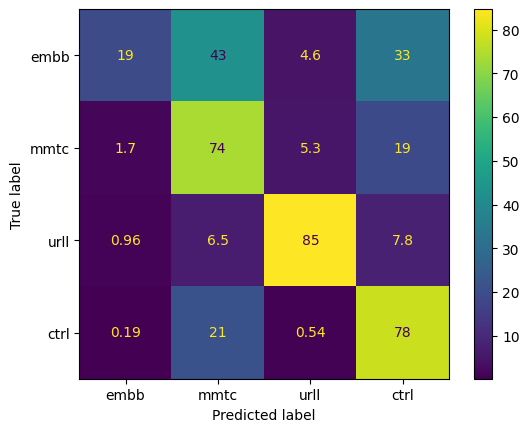

In [69]:
cm = confusion_matrix(y_test, rft.predict(X_test), labels=rft.classes_)
cm = cm.astype('float')
for r in range(cm.shape[0]):  # for each row in the confusion matrix
    sum_row = np.sum(cm[r, :])
    cm[r, :] = cm[r, :] / float(sum_row)  * 100.0 # compute in percentage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.values())
disp.plot()
plt.savefig(f"Results_finetune.pdf")